In [ ]:
%load_ext autoreload
%autoreload 2

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from olist.seller import Seller
from olist.product import Product
from olist.data import Olist
from olist.order import Order
from ipywidgets import interact, IntSlider, Dropdown

In [24]:
olist = Olist()
data_olist = olist.get_data()

In [25]:
seller = Seller()
data_sellers = seller.get_training_data()

In [26]:
data_sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,...,sales,sales_fees,subscription_fees,revenues,cost,number_of_items,profits,share_of_five_stars,share_of_one_stars,review_score
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,...,218.70,21.870,320.0,341.870,140,3,201.870,0.333333,0.333333,3.000000
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,...,11703.07,1170.307,1120.0,2290.307,240,41,2050.307,0.731707,0.048780,4.560976
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,...,158.00,15.800,0.0,15.800,0,1,15.800,1.000000,0.000000,5.000000
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,1,1,...,79.99,7.999,0.0,7.999,0,1,7.999,1.000000,0.000000,5.000000
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1,1,...,167.99,16.799,0.0,16.799,100,1,-83.201,0.000000,1.000000,1.000000


In [27]:
order = Order()
data_orders = order.get_training_data()

/home/lewagon/code/espiautlewagon/04-Decision-Science/01-Project-Setup/data-context-and-setup/olist/order.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivered_orders[i] = pd.to_datetime(delivered_orders[i])
/home/lewagon/code/espiautlewagon/04-Decision-Science/01-Project-Setup/data-context-and-setup/olist/order.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivered_orders[i] = pd.to_datetime(delivered_orders[i])
/home/lewagon/code/espiautlewagon/04-Decision-Science/01-Project-Setup/data-co

In [28]:
data_orders.head()

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_items,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,8.0,15,7.0,delivered,False,False,4,1,1,29.99,8.72,18.063837
1,53cdb2fc8bc7dce0b6741e2150273451,13.0,19,6.0,delivered,False,False,4,1,1,118.70,22.76,856.292580
2,47770eb9100c2d0c44946d9cf07ec65d,9.0,26,17.0,delivered,True,False,5,1,1,159.90,19.22,514.130333
3,949d5b44dbf5de918fe9c16f97b45f8a,13.0,26,13.0,delivered,True,False,5,1,1,45.00,27.20,1822.800366
4,ad21c59c0840e6cb83a9ceb5573f8159,2.0,12,10.0,delivered,True,False,5,1,1,19.90,8.72,30.174037


In [31]:
# Load the geolocation data
data_geoloc = data_olist["geolocation"].drop_duplicates(subset="geolocation_state")
data_sellers = data_sellers.sort_values(by="profits")
data_items = data_olist["order_items"]

# Define constants
alpha = 3157.27
beta = 978.23
it_cost_init = 500_000


# Define the it_cost_update function
def it_cost_update(n_sellers, n_items):
    return alpha * np.sqrt(n_sellers) + beta * np.sqrt(n_items)


# Perform the analysis to get the result
def analysis(df):
    data_sellers_sorted = df.sort_values(by="profits")
    result = []
    profit_max = 0
    n_sellers_removed = 0

    for i in range(len(data_sellers_sorted)):
        n_sellers = i
        n_sellers_remaining = len(data_sellers_sorted) - i
        n_items_remaining = data_sellers_sorted.iloc[i:]["number_of_items"].sum()
        
        it_costs = it_cost_update(n_sellers_remaining, n_items_remaining)
        
        profit = data_sellers_sorted.iloc[i:]["profits"].sum() - it_costs
        
        if profit >= profit_max:
            profit_max = profit
            n_sellers_removed = i + 1
        result.append((n_sellers, profit))

    print(f"Max Profit: {profit_max} BRL")
    print(f"Removed Sellers: {n_sellers_removed}")

    return result, n_sellers_removed, profit_max

# Interactive function to update the plot
def plot_update(n_removed, column_training, column_order_items):
    fig, axs = plt.subplots(2, 2, figsize=(20, 20))

    # Plot the profit data
    ax1 = axs[0, 0]
    ax1.plot(data_profit["n_sellers_removed"], data_profit["profit"], marker="o")
    ax1.axvline(
        x=n_removed, color="r", linestyle="--", label=f"Removed Sellers: {n_removed}"
    )
    ax1.set_title("Increasing profit by removing worst performing sellers")
    ax1.set_xlabel("Number of Removed Sellers")
    ax1.set_ylabel("Total Profit (BRL)")
    ax1.grid(True)
    ax1.legend()

    # Update the map
    sellers_worst = worst_sellers.head(n_removed)

    # Plot the most sold products by the removed sellers
    ax3 = axs[1, 0]
    seller_ids_removed = sellers_worst["seller_id"]
    order_items_removed = data_items[
        data_items["seller_id"].isin(seller_ids_removed)
    ]
    most_sold_products = order_items_removed[column_order_items].value_counts().head(10)
    most_sold_products.plot(kind="bar", ax=ax3, color="skyblue")
    ax3.set_title(f"Most Common {column_order_items} by Removed Sellers")
    ax3.set_xlabel(column_order_items)
    ax3.set_ylabel("Count")

    # Plot the chosen column data for removed sellers
    ax4 = axs[1, 1]
    column_data = data_sellers[data_sellers["seller_id"].isin(seller_ids_removed)][
        column_training
    ]  # .groupby('seller_id')[column_training].mean().astype(int)
    column_data.hist(ax=ax4, color="lightgreen", bins=20)
    ax4.set_title(f"Distribution of {column_training} from Removed Sellers")
    ax4.set_xlabel(f"{column_training} per seller")
    ax4.set_ylabel(f"{column_training} per seller")

    plt.tight_layout()
    plt.show()


# Analyze data
result, n_sellers_removed, profit_max = analysis(data_sellers)
data_profit = pd.DataFrame(result, columns=["n_sellers_removed", "profit"])

# Prepare the geolocation data
data_sellers_sorted = data_sellers.sort_values(by="profits")
data_sellers_geoloc = pd.merge(
    data_sellers_sorted, data_geoloc, left_on="seller_state", right_on="geolocation_state"
)

# Sort sellers by increasing profits and select the worst performing sellers
worst_sellers = data_sellers_geoloc.sort_values(by="profits")

# Create a GeoDataFrame for the worst performing sellers
gdf_worst_sellers = gpd.GeoDataFrame(
    worst_sellers,
    geometry=gpd.points_from_xy(
        worst_sellers.geolocation_lng, worst_sellers.geolocation_lat
    ),
    crs="EPSG:4326",
)

# Create interactive widgets
columns_training = data_sellers.columns.tolist()
columns_order_items = data_items.columns.tolist()
interact(
    plot_update,
    n_removed=IntSlider(min=1, max=len(worst_sellers), step=1, value=1),
    column_training=Dropdown(
        options=columns_training,
        value="review_score",
        description="Training Data Column:",
    ),
    column_order_items=Dropdown(
        options=columns_order_items,
        value="product_id",
        description="Order Items Column:",
    ),
)

Max Profit: 1070976.1160162983 BRL
Removed Sellers: 856


interactive(children=(IntSlider(value=1, description='n_removed', max=2967, min=1), Dropdown(description='Trai…

<function __main__.plot_update(n_removed, column_training, column_order_items)>

# CEO-Report -  How could Olist improve its profit?


**Assumptions:**

<u>Revenues:</u> sales fees - Rewview-costs - IT-costs

<u>Sales fees:</u> Olist takes a 10% cut on the product price (excl. freight) of each order
<u>Subscription fees:</u> Olist charges 80 BRL by month per seller

<u>Costs:</u>
Reputation costs estimated per order with bad reviews (<= 3 stars)

The IT costs formula is given by:
$ \text{IT-costs} = 3157.27 \times \sqrt{n_{\text{sellers}}} + 978.23 \times \sqrt{n_{\text{items}}}$
 

##  Olist can improve its profit by 50% up to 1 Mio. BRL by removing 3% of the sellers?

### Exclude sellers

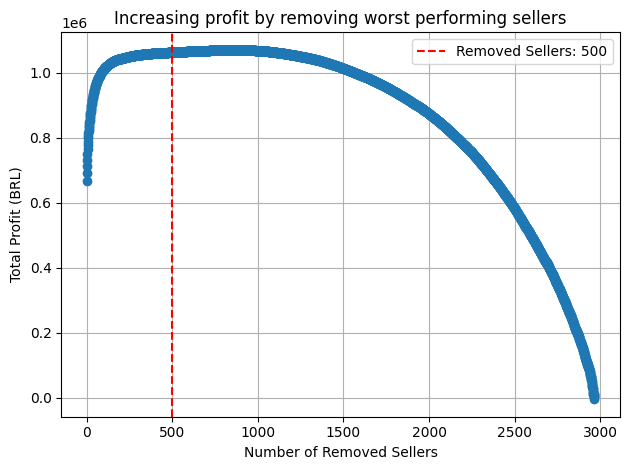

In [42]:
plt.plot(data_profit["n_sellers_removed"], data_profit["profit"], marker="o")
plt.axvline(x=500, color="r", linestyle="--", label=f"Removed Sellers: {500}")
plt.title("Increasing profit by removing worst performing sellers")
plt.xlabel("Number of Removed Sellers")
plt.ylabel("Total Profit (BRL)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### Remove products

### Exclude specific seller/customer pairs

#### Why?

Max Profit: 1070976.1160162983 BRL
Removed Sellers: 856


interactive(children=(IntSlider(value=1, description='n_removed', max=2967, min=1), Dropdown(description='Trai…

<function __main__.plot_update(n_removed, column_training, column_order_items)>

/tmp/ipykernel_15892/877245202.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_ids.drop_duplicates(inplace=True)


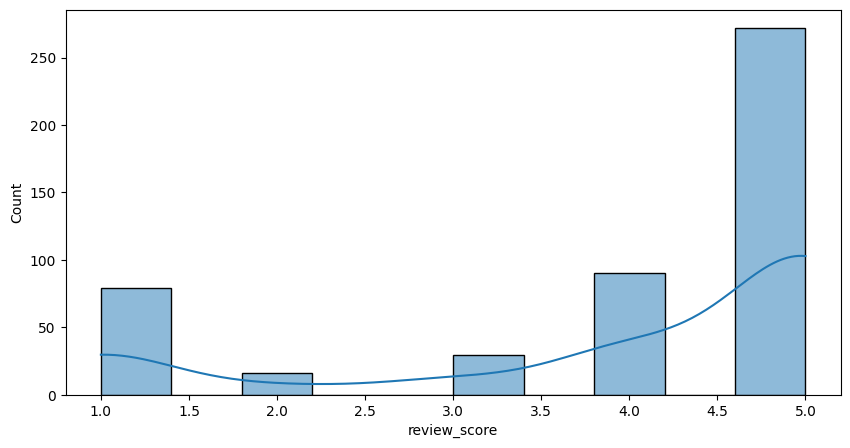

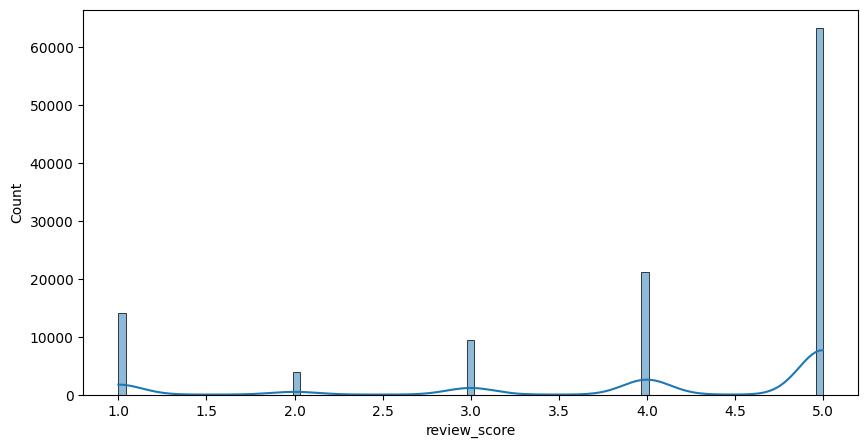

In [5]:
order_order_items = pd.DataFrame.merge(data['orders'], data['order_items'])
order_order_items_reviews = order_order_items.merge(data['order_reviews'][['review_id', 'review_score', 'order_id']], on='order_id')
order_order_items_reviews = order_order_items_reviews[['customer_id', 'order_id', 'seller_id', 'review_score', 'product_id']]
product = order_order_items_reviews.query("product_id == '422879e10f46682990de24d770e7f83d'")
other_products = order_order_items_reviews.query("product_id != '422879e10f46682990de24d770e7f83d'")
order_ids = product.query("review_score == 1")
order_ids.drop_duplicates(inplace=True)
#order_order_items_reviews = order_order_items_reviews.drop_duplicates()
#print(order_ids)

fig_1 = plt.figure(figsize=(10, 5))
sns.histplot(data=product, x='review_score', kde=True)

fig_2 = plt.figure(figsize=(10, 5))
sns.histplot(data=other_products, x='review_score', kde=True)
plt.show()